In [3]:
from collector.collector_factory import CollectorFactory
from writer.writer_factory import WriterFactory
import numpy as np
import pandas as pd
import os
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn.functional as F

### 1. Collect and write data

In [4]:
collector = CollectorFactory.initialize_collector('APIncbi')
writer = WriterFactory.initialize_writer('FileWriter')
writer.set_path('./data')

unique_sequences = set()
n = 100000

for seq_object in collector.collect(n):
    sequence = seq_object[1]
    
    if sequence not in unique_sequences:
        writer.write(seq_object[0], str(sequence))
        unique_sequences.add(sequence)

print(f'Unique sequences: {len(unique_sequences)}')

10272 results found.
Unique sequences: 3563


### 2.1 Get data

In [6]:
aminoacids = 'ACDEFGHIKLMNPQRSTVWYXBJU'
amino_dict = {amino: idx for idx, amino in enumerate(aminoacids)}

def one_hot_encode(secuencia, max_length):
    encoding = np.zeros((max_length, len(aminoacids)))
    
    for i, amino in enumerate(secuencia):
        if amino not in amino_dict:
            print("Unrecognized amino acid:", amino)
        else:
            encoding[i, amino_dict[amino]] = 1
    return encoding.flatten()

data = []

for seq in unique_sequences:
    data.append({'sequence': str(seq)})

max_length = max(len(record['sequence']) for record in data)

df = pd.DataFrame(data)

display(df.head())

,sequence
0,MVGLKPSDVPPTMAVKFLGAGTAACFADLVTFPLDTAKVRLQIQGE...
1,MLLWPLRGWAARALRCFGPGSRGSPASGPGPRRVQRRAWPPDKEQE...
2,SGTLSLTCSVSGVSMSAYYWSWIRQSPGKGLEWIGYMYYAGSSNYN...
3,MAPFLRIAFNSYELGSLQAEDEANQPFCAVKMKEALSTERGKTLVQ...
4,MKSCAVSLTTAAVAFGDEAKKMAEGKASRESEEESVSLTVEEREAL...


### 2.1. Encoding the data with a variation of bag of words

In [7]:
def alpha(i, n):
    return (n - i) * 1 / n

aminoacids = 'ACDEFGHIKLMNPQRSTVWYXBJU'
dict_amino = {amino: idx for idx, amino in enumerate(aminoacids)}


def get_vector_byMaxN(seq, alpha,n):
    v = np.zeros(len(aminoacids)) 
    for i in range(len(seq)):
        pos = dict_amino[seq[i]]
        v[pos] += 1 * alpha(i, n)
    return v

def get_vector_bySeqN(seq, alpha):
    n = len(seq)
    v = np.zeros(len(aminoacids)) 
    for i in range(len(seq)):
        pos = dict_amino[seq[i]]
        v[pos] += 1 * alpha(i, n)
    return v

In [8]:
n = max(len(record['sequence']) for record in data)
v = get_vector_byMaxN(df['sequence'][0], alpha, n)
df['vectorMaxN'] = df['sequence'].apply(lambda x: get_vector_byMaxN(x, alpha, n))
df['vectorSeqN'] = df['sequence'].apply(lambda x: get_vector_bySeqN(x, alpha))

In [9]:
display(df.head())

,sequence,vectorMaxN,vectorSeqN
0,MVGLKPSDVPPTMAVKFLGAGTAACFADLVTFPLDTAKVRLQIQGE...,"[26.289396602226127, 7.755711775043937, 12.638...","[15.336538461538462, 3.990384615384615, 7.0705..."
1,MLLWPLRGWAARALRCFGPGSRGSPASGPGPRRVQRRAWPPDKEQE...,"[12.754344854520602, 5.8582308142940835, 9.736...","[7.906882591093117, 3.0607287449392713, 4.5465..."
2,SGTLSLTCSVSGVSMSAYYWSWIRQSPGKGLEWIGYMYYAGSSNYN...,"[6.910564342901777, 1.9830111306385472, 1.9744...","[2.7196261682242993, 1.1869158878504673, 0.775..."
3,MAPFLRIAFNSYELGSLQAEDEANQPFCAVKMKEALSTERGKTLVQ...,"[37.01093536418669, 19.916617848076545, 36.912...","[23.931952662721894, 12.792899408284024, 16.60..."
4,MKSCAVSLTTAAVAFGDEAKKMAEGKASRESEEESVSLTVEEREAL...,"[59.96641280999805, 17.66198008201523, 27.9160...","[35.97286295793757, 9.702849389416553, 15.5196..."


## 3. Unsupervised Learning

### 3.1. DBSCAN with vectorMaxN

In [10]:
X = np.array(df['vectorMaxN'].tolist())
X_scaled = StandardScaler().fit_transform(X)

eps_values = np.arange(0.5, 2.0, 0.1) 
min_samples_values = range(30, 100, 10)

best_eps = None
best_min_samples = None
min_noise_points = float('inf')
best_clusters = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_scaled)

        num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        noise_points = list(clusters).count(-1)

        if num_clusters >= 4 and noise_points > 0:
            if noise_points < min_noise_points:
                min_noise_points = noise_points
                best_eps = eps
                best_min_samples = min_samples
                best_clusters = clusters

dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)
clusters_best = dbscan_best.fit_predict(X_scaled)
df['cluster-vectorMaxN'] = clusters_best

In [11]:
print(f"Best configuration found: eps={best_eps}, min_samples={best_min_samples}")
print(f"Minimum number of samples in -1 (noise): {min_noise_points}")
print(f"Number of clusters (excluding -1): {len(set(best_clusters)) - (1 if -1 in best_clusters else 0)} \n")

print("Cluster sizes:")
print(df['cluster-vectorMaxN'].value_counts())

Best configuration found: eps=0.8999999999999999, min_samples=30
Minimum number of samples in -1 (noise): 2147
Number of clusters (excluding -1): 4 

Cluster sizes:
cluster-vectorMaxN
-1    2147
 0    1210
 1      82
 3      73
 2      51
Name: count, dtype: int64


#### 3.1.1 Principal Component Analysis (PCA)

In [12]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

pca_3d = PCA(n_components=3)
principalComponents3d = pca_3d.fit_transform(X_scaled)

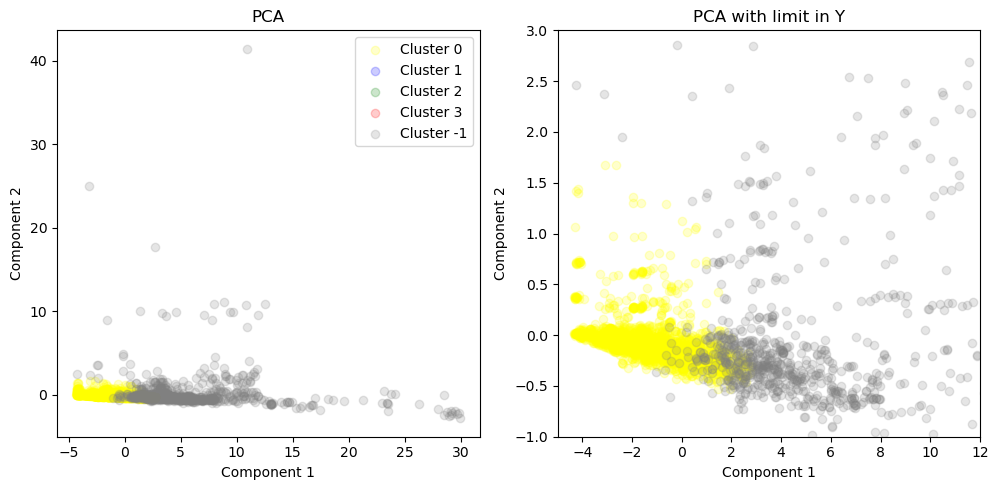

In [13]:
colors = {
    0: 'yellow',
    1: 'blue',
    2: 'green',
    3: 'red',
    -1: 'gray'
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

for cluster in colors:
    ax1.scatter(principalComponents[clusters == cluster, 0],
                principalComponents[clusters == cluster, 1],
                color=colors[cluster], alpha=0.2, label=f'Cluster {cluster}')

ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.set_title('PCA')
ax1.legend()

for cluster in colors:
    ax2.scatter(principalComponents[clusters == cluster, 0],
                principalComponents[clusters == cluster, 1],
                color=colors[cluster], alpha=0.2, label=f'Cluster {cluster}')

ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
ax2.set_title('PCA with limit in Y')
ax2.set_ylim(-1, 3)
ax2.set_xlim(-5, 12)

plt.tight_layout()
plt.show()

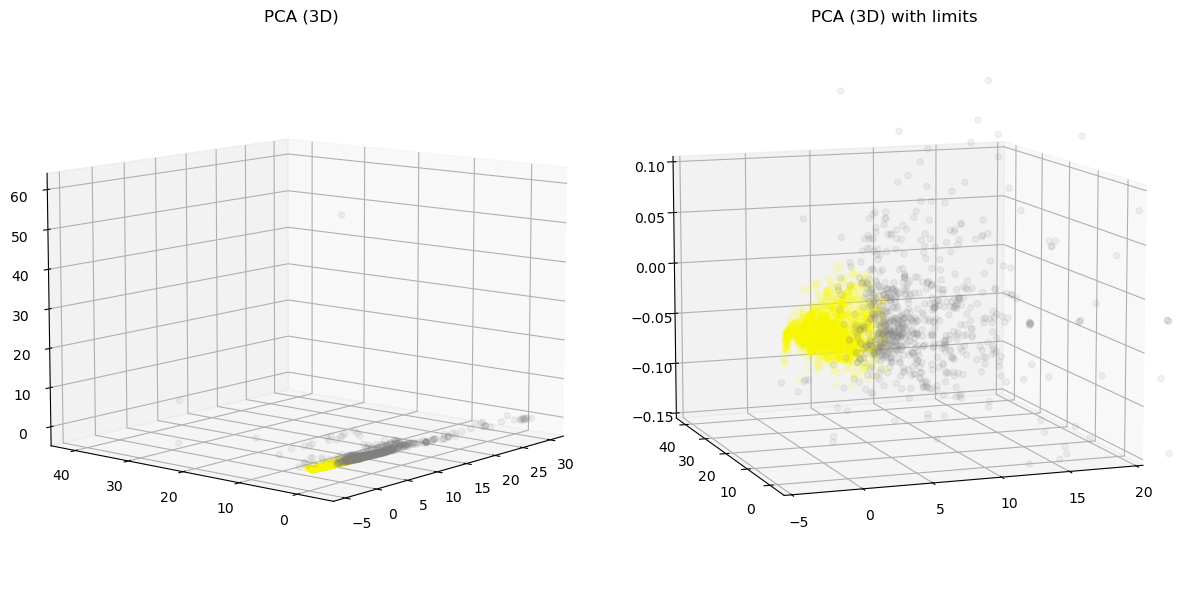

In [14]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
for cluster in colors:
    ax1.scatter(principalComponents3d[clusters == cluster, 0],
                principalComponents3d[clusters == cluster, 1],
                principalComponents3d[clusters == cluster, 2],
                color=colors[cluster], alpha=0.1, label=f'Cluster {cluster}')
ax1.set_title('PCA (3D)')
ax1.view_init(10, 220)

ax2 = fig.add_subplot(122, projection='3d')
for cluster in colors:
    ax2.scatter(principalComponents3d[clusters == cluster, 0],
                principalComponents3d[clusters == cluster, 1],
                principalComponents3d[clusters == cluster, 2],
                color=colors[cluster], alpha=0.1, label=f'Cluster {cluster}')
ax2.set_title('PCA (3D) with limits')
ax2.set_zlim(-0.15, 0.1)
ax2.set_xlim(-5, 20)
ax2.view_init(10, 250)

plt.tight_layout()
plt.show()


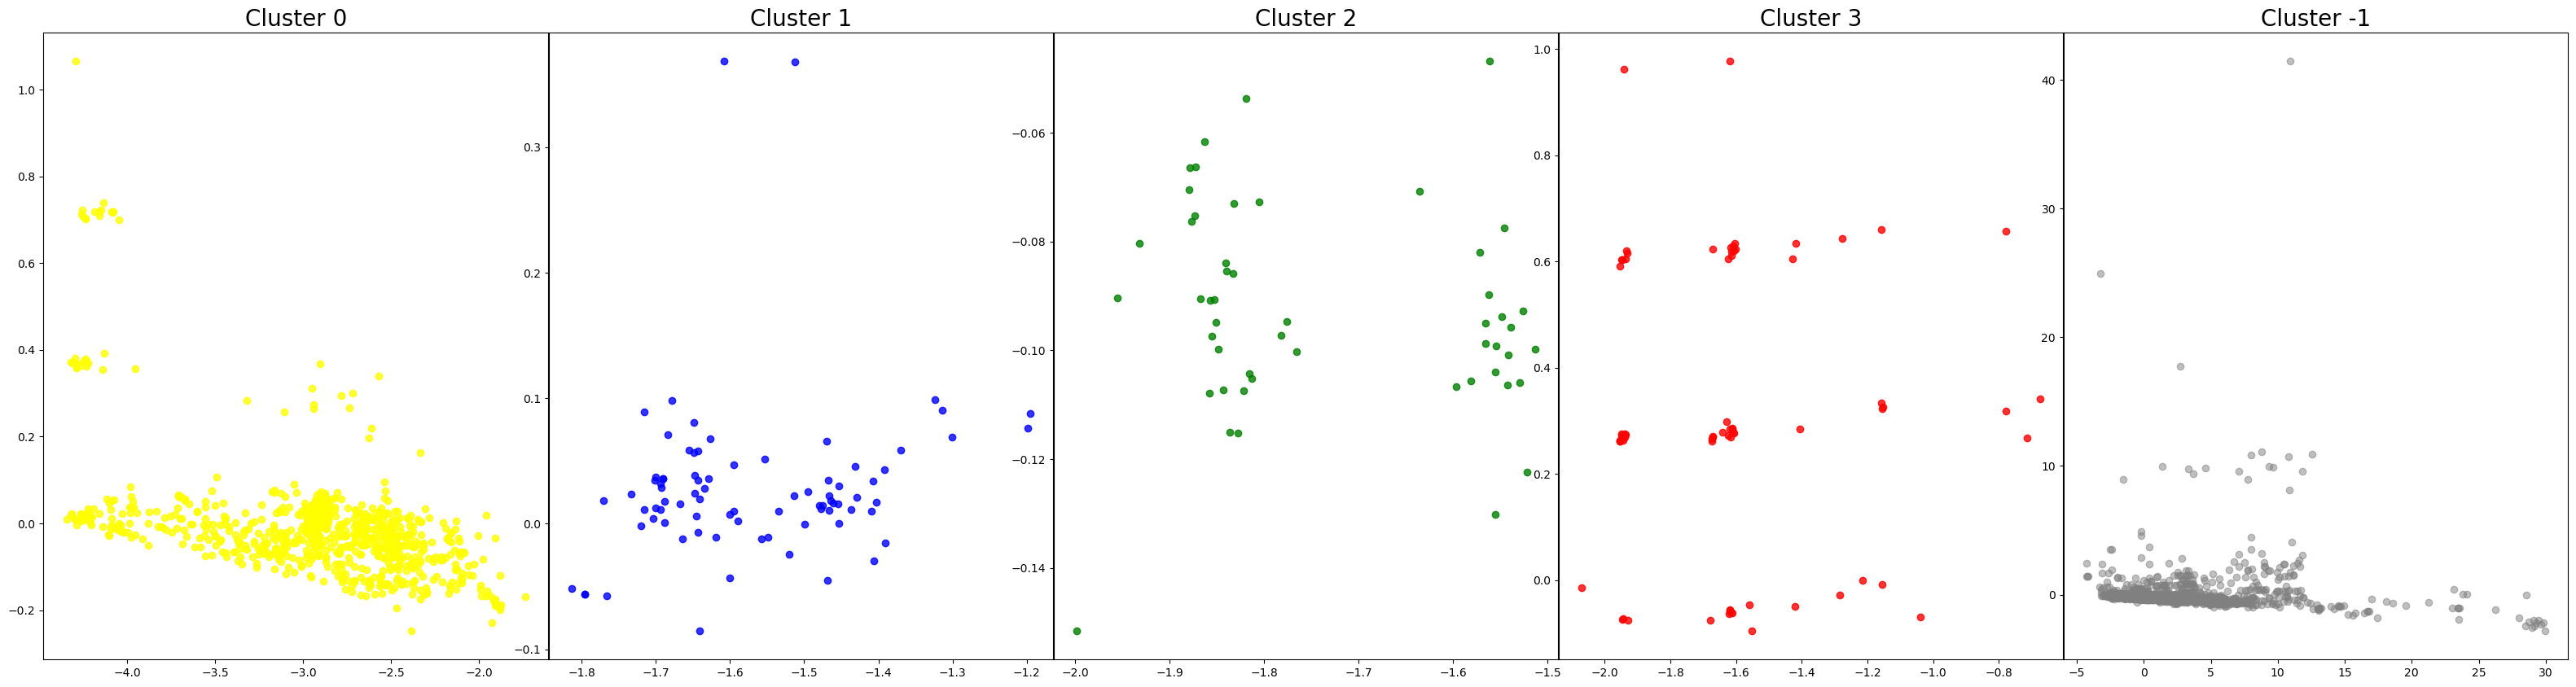

In [15]:
num_clusters = len(set(df['cluster-vectorMaxN'])) - (1 if -1 in df['cluster-vectorMaxN'].values else 0)

fig, axs = plt.subplots(1, num_clusters + 1, figsize=(40, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.001)
axs = axs.ravel()

for i in range(num_clusters):
    cluster = df[df['cluster-vectorMaxN'] == i]
    axs[i].scatter(principalComponents[cluster.index, 0], principalComponents[cluster.index, 1],
                   color=colors[i], alpha=0.8)
    axs[i].set_title(f'Cluster {i}', fontsize=20)

cluster = df[df['cluster-vectorMaxN'] == -1]
axs[num_clusters].scatter(principalComponents[cluster.index, 0], principalComponents[cluster.index, 1],
                           color=colors[-1], alpha=0.5)
axs[num_clusters].set_title('Cluster -1', fontsize=20)

plt.show()

### 3.2. DBSCAN with vectorSeqN

In [16]:
X = np.array(df['vectorSeqN'].tolist())
X_scaled = StandardScaler().fit_transform(X)

eps_values = np.arange(0.5, 2.0, 0.1) 
min_samples_values = range(30, 100, 10)

best_eps = None
best_min_samples = None
min_noise_points = float('inf')
best_clusters = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_scaled)

        num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        noise_points = list(clusters).count(-1)

        if num_clusters >= 4 and noise_points > 0:
            if noise_points < min_noise_points:
                min_noise_points = noise_points
                best_eps = eps
                best_min_samples = min_samples
                best_clusters = clusters

dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)
clusters_best = dbscan_best.fit_predict(X_scaled)
df['cluster-vectorSeqN'] = clusters_best

In [17]:
print(f"Best configuration found: eps={best_eps}, min_samples={best_min_samples}")
print(f"Minimum number of samples in -1 (noise): {min_noise_points}")
print(f"Number of clusters (excluding -1): {len(set(best_clusters)) - (1 if -1 in best_clusters else 0)} \n")

print("Cluster sizes:")
print(df['cluster-vectorSeqN'].value_counts())

Best configuration found: eps=0.7, min_samples=30
Minimum number of samples in -1 (noise): 2292
Number of clusters (excluding -1): 5 

Cluster sizes:
cluster-vectorSeqN
-1    2292
 0    1077
 2      69
 1      52
 4      39
 3      34
Name: count, dtype: int64


#### 3.2.1 Principal Component Analysis (PCA)

In [18]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

pca_3d = PCA(n_components=3)
principalComponents3d = pca_3d.fit_transform(X_scaled)

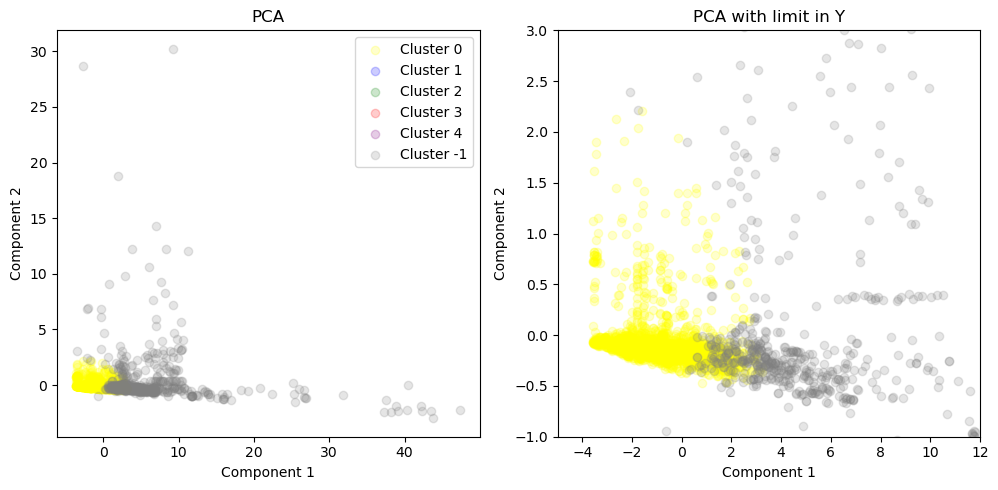

In [19]:
colors = {
    0: 'yellow',
    1: 'blue',
    2: 'green',
    3: 'red',
    4: 'purple',
    -1: 'gray'
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

for cluster in colors:
    ax1.scatter(principalComponents[clusters == cluster, 0],
                principalComponents[clusters == cluster, 1],
                color=colors[cluster], alpha=0.2, label=f'Cluster {cluster}')

ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.set_title('PCA')
ax1.legend()

for cluster in colors:
    ax2.scatter(principalComponents[clusters == cluster, 0],
                principalComponents[clusters == cluster, 1],
                color=colors[cluster], alpha=0.2, label=f'Cluster {cluster}')

ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
ax2.set_title('PCA with limit in Y')
ax2.set_ylim(-1, 3)
ax2.set_xlim(-5, 12)

plt.tight_layout()
plt.show()

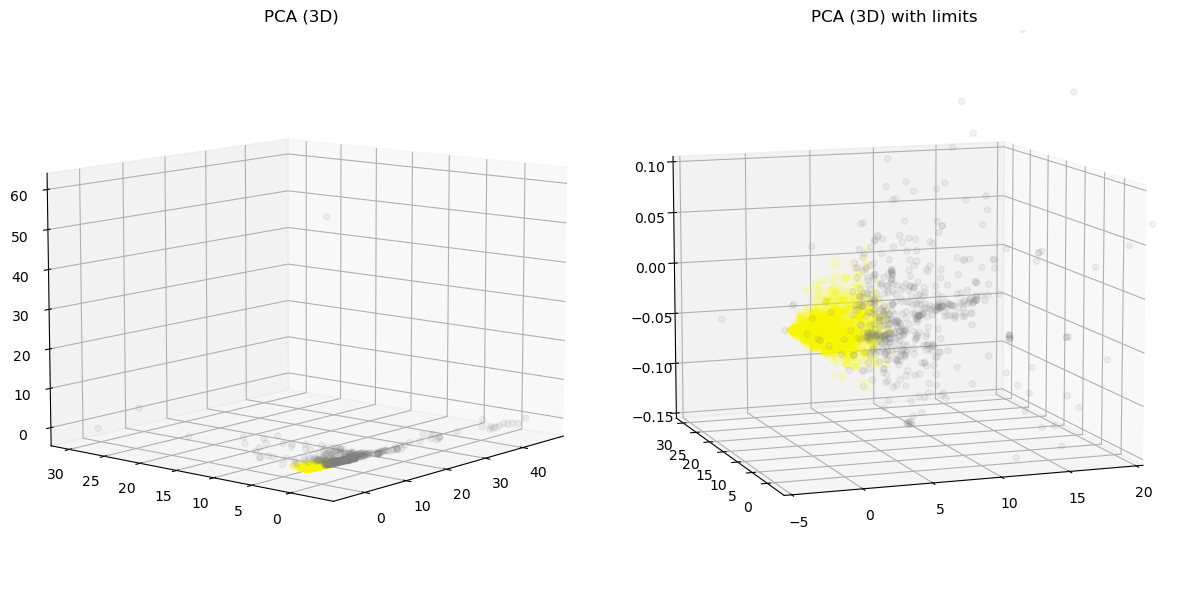

In [20]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
for cluster in colors:
    ax1.scatter(principalComponents3d[clusters == cluster, 0],
                principalComponents3d[clusters == cluster, 1],
                principalComponents3d[clusters == cluster, 2],
                color=colors[cluster], alpha=0.1, label=f'Cluster {cluster}')
ax1.set_title('PCA (3D)')
ax1.view_init(10, 220)

ax2 = fig.add_subplot(122, projection='3d')
for cluster in colors:
    ax2.scatter(principalComponents3d[clusters == cluster, 0],
                principalComponents3d[clusters == cluster, 1],
                principalComponents3d[clusters == cluster, 2],
                color=colors[cluster], alpha=0.1, label=f'Cluster {cluster}')
ax2.set_title('PCA (3D) with limits')
ax2.set_zlim(-0.15, 0.1)
ax2.set_xlim(-5, 20)
ax2.view_init(10, 250)

plt.tight_layout()
plt.show()

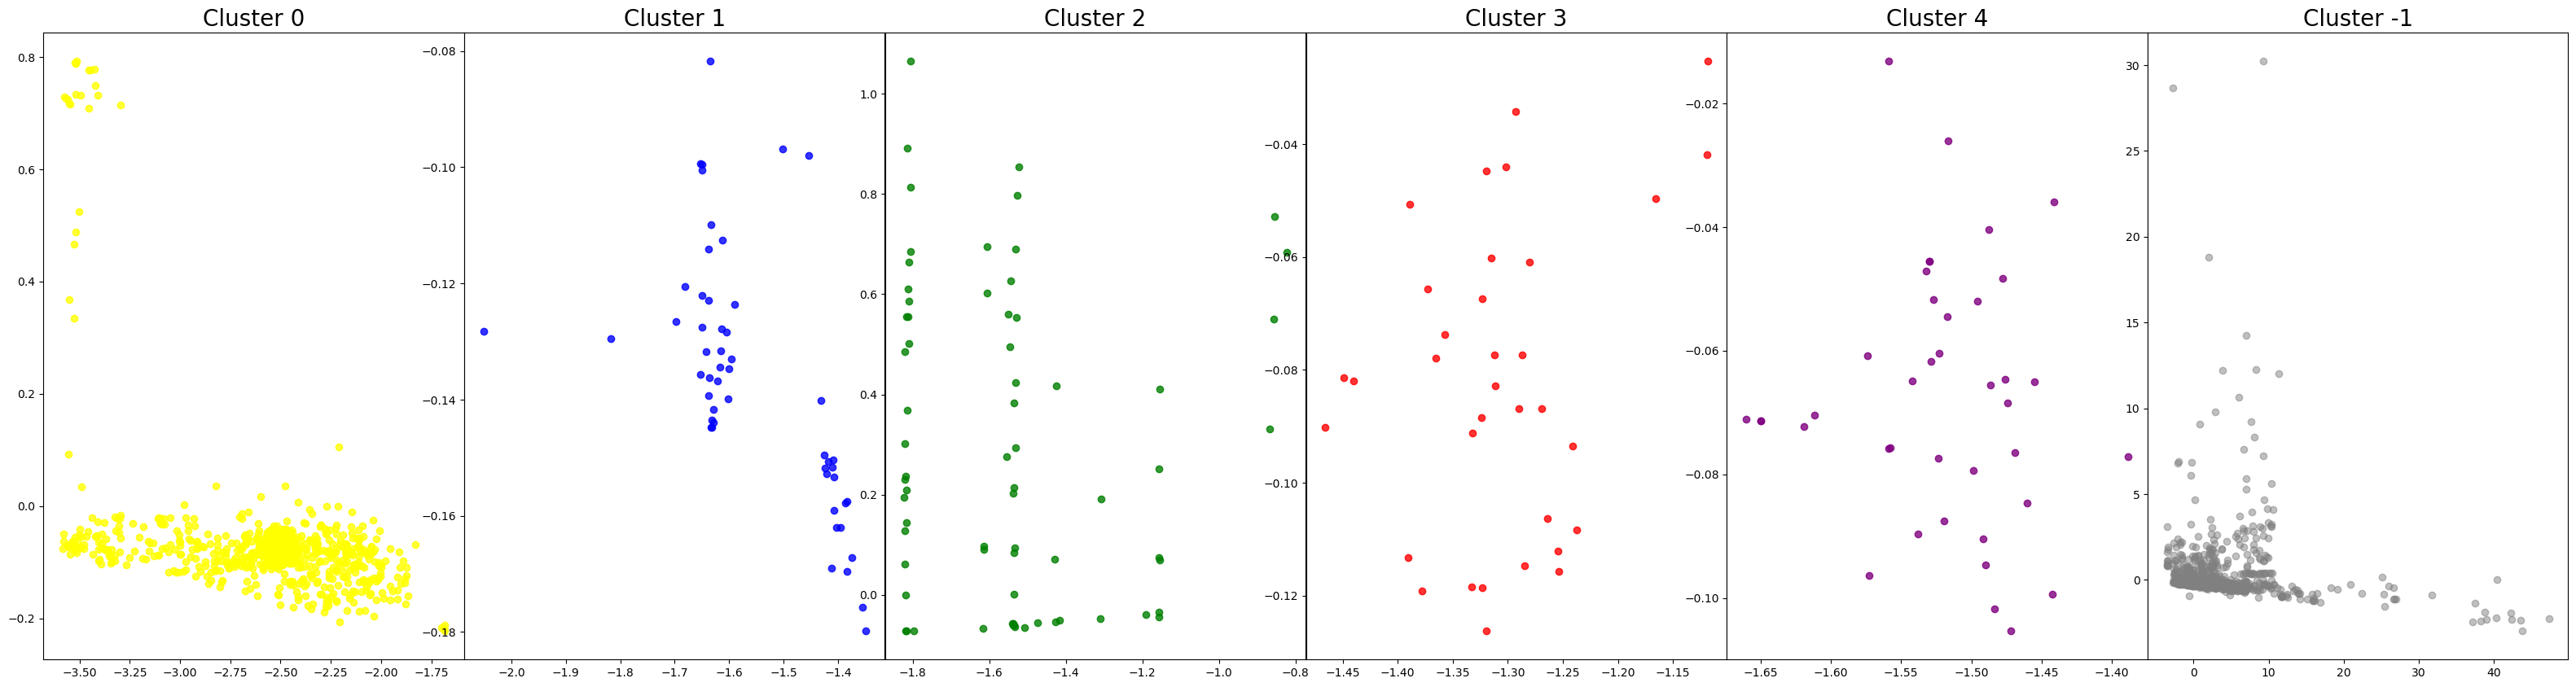

In [21]:
num_clusters = len(set(df['cluster-vectorSeqN'])) - (1 if -1 in df['cluster-vectorSeqN'].values else 0)

fig, axs = plt.subplots(1, num_clusters + 1, figsize=(40, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.001)
axs = axs.ravel()

for i in range(num_clusters):
    cluster = df[df['cluster-vectorSeqN'] == i]
    axs[i].scatter(principalComponents[cluster.index, 0], principalComponents[cluster.index, 1],
                   color=colors[i], alpha=0.8)
    axs[i].set_title(f'Cluster {i}', fontsize=20)

cluster = df[df['cluster-vectorSeqN'] == -1]
axs[num_clusters].scatter(principalComponents[cluster.index, 0], principalComponents[cluster.index, 1],
                           color=colors[-1], alpha=0.5)
axs[num_clusters].set_title('Cluster -1', fontsize=20)

plt.show()

### 3.3. K-means with vectorMaxN

In [33]:
X = np.array(df['vectorMaxN'].tolist())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
k_values = range(1, 10, 1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

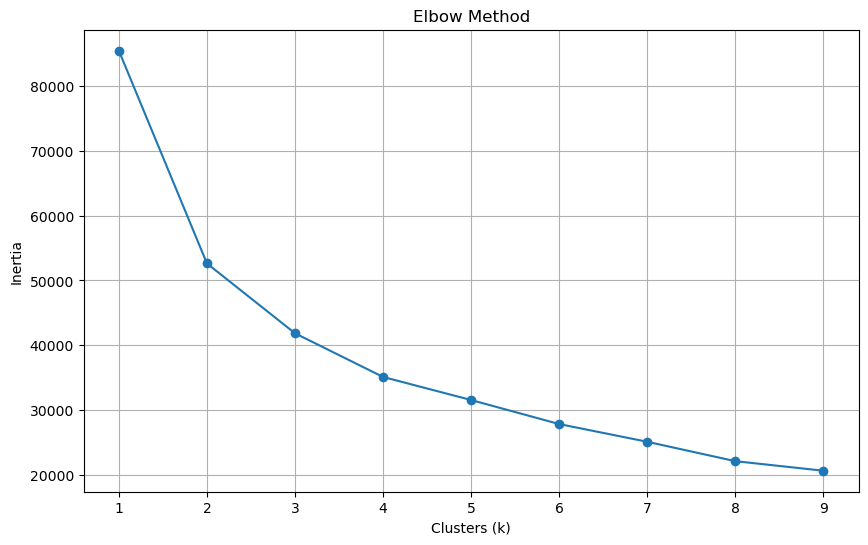

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

In our case, when applying the Elbow Method, we observe that the elbow occurs at $k=4$. This indicates that, although increasing the number of clusters to larger values might still reduce the inertia, the benefits in terms of clustering quality become marginal. Therefore, we select 4 clusters as the most balanced option, which provides a clear segmentation of the data without complicating the model unnecessarily.

In [39]:
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(X_scaled)

df['cluster-vectorMaxN-kmeans'] = clusters

#### 3.3.1 Principal Component Analysis (PCA)

In [40]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

pca_3d = PCA(n_components=3)
principalComponents3d = pca_3d.fit_transform(X_scaled)

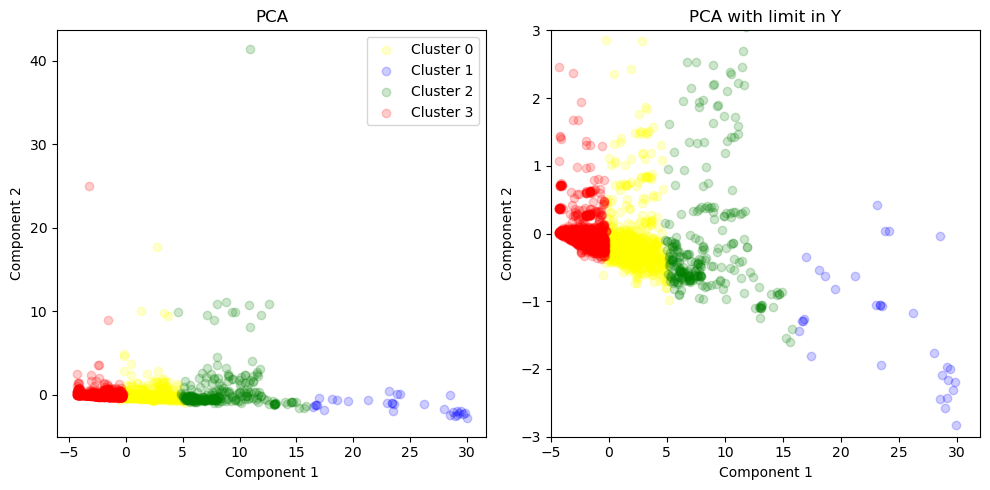

In [47]:
colors = {
    0: 'yellow',
    1: 'blue',
    2: 'green',
    3: 'red',
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

for cluster in colors:
    ax1.scatter(principalComponents[clusters == cluster, 0],
                principalComponents[clusters == cluster, 1],
                color=colors[cluster], alpha=0.2, label=f'Cluster {cluster}')

ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.set_title('PCA')
ax1.legend()

for cluster in colors:
    ax2.scatter(principalComponents[clusters == cluster, 0],
                principalComponents[clusters == cluster, 1],
                color=colors[cluster], alpha=0.2, label=f'Cluster {cluster}')

ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
ax2.set_title('PCA with limit in Y')
ax2.set_ylim(-3, 3)
ax2.set_xlim(-5, 32)

plt.tight_layout()
plt.show()

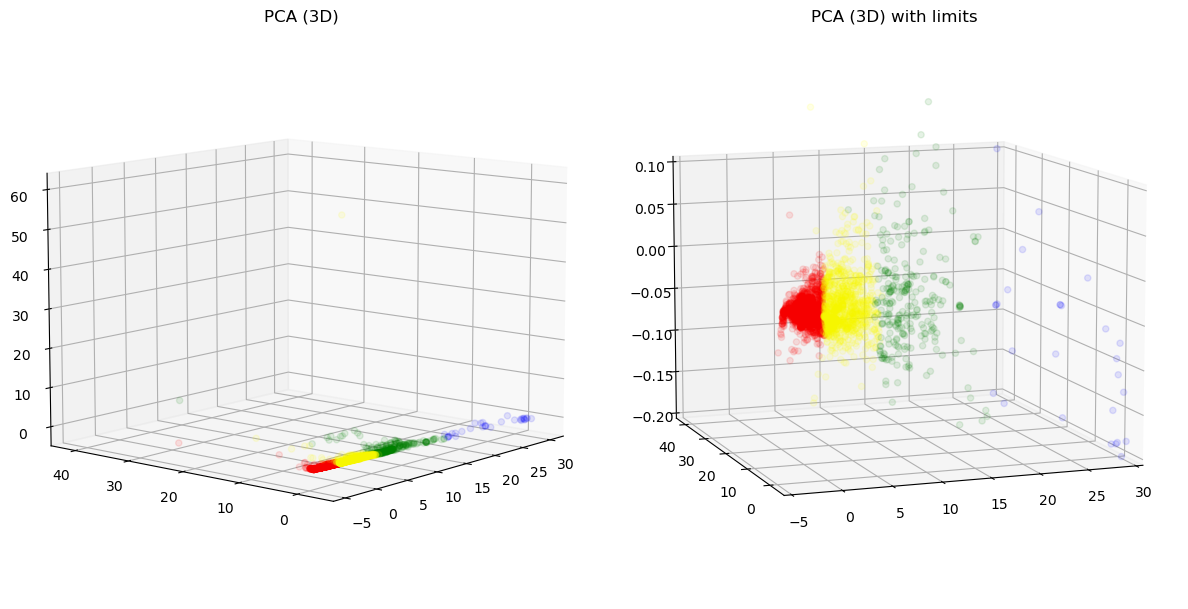

In [56]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
for cluster in colors:
    ax1.scatter(principalComponents3d[clusters == cluster, 0],
                principalComponents3d[clusters == cluster, 1],
                principalComponents3d[clusters == cluster, 2],
                color=colors[cluster], alpha=0.1, label=f'Cluster {cluster}')
ax1.set_title('PCA (3D)')
ax1.view_init(10, 220)

ax2 = fig.add_subplot(122, projection='3d')
for cluster in colors:
    ax2.scatter(principalComponents3d[clusters == cluster, 0],
                principalComponents3d[clusters == cluster, 1],
                principalComponents3d[clusters == cluster, 2],
                color=colors[cluster], alpha=0.1, label=f'Cluster {cluster}')
ax2.set_title('PCA (3D) with limits')
ax2.set_zlim(-0.2, 0.1)
ax2.set_xlim(-5, 30)
ax2.view_init(10, 250)

plt.tight_layout()
plt.show()

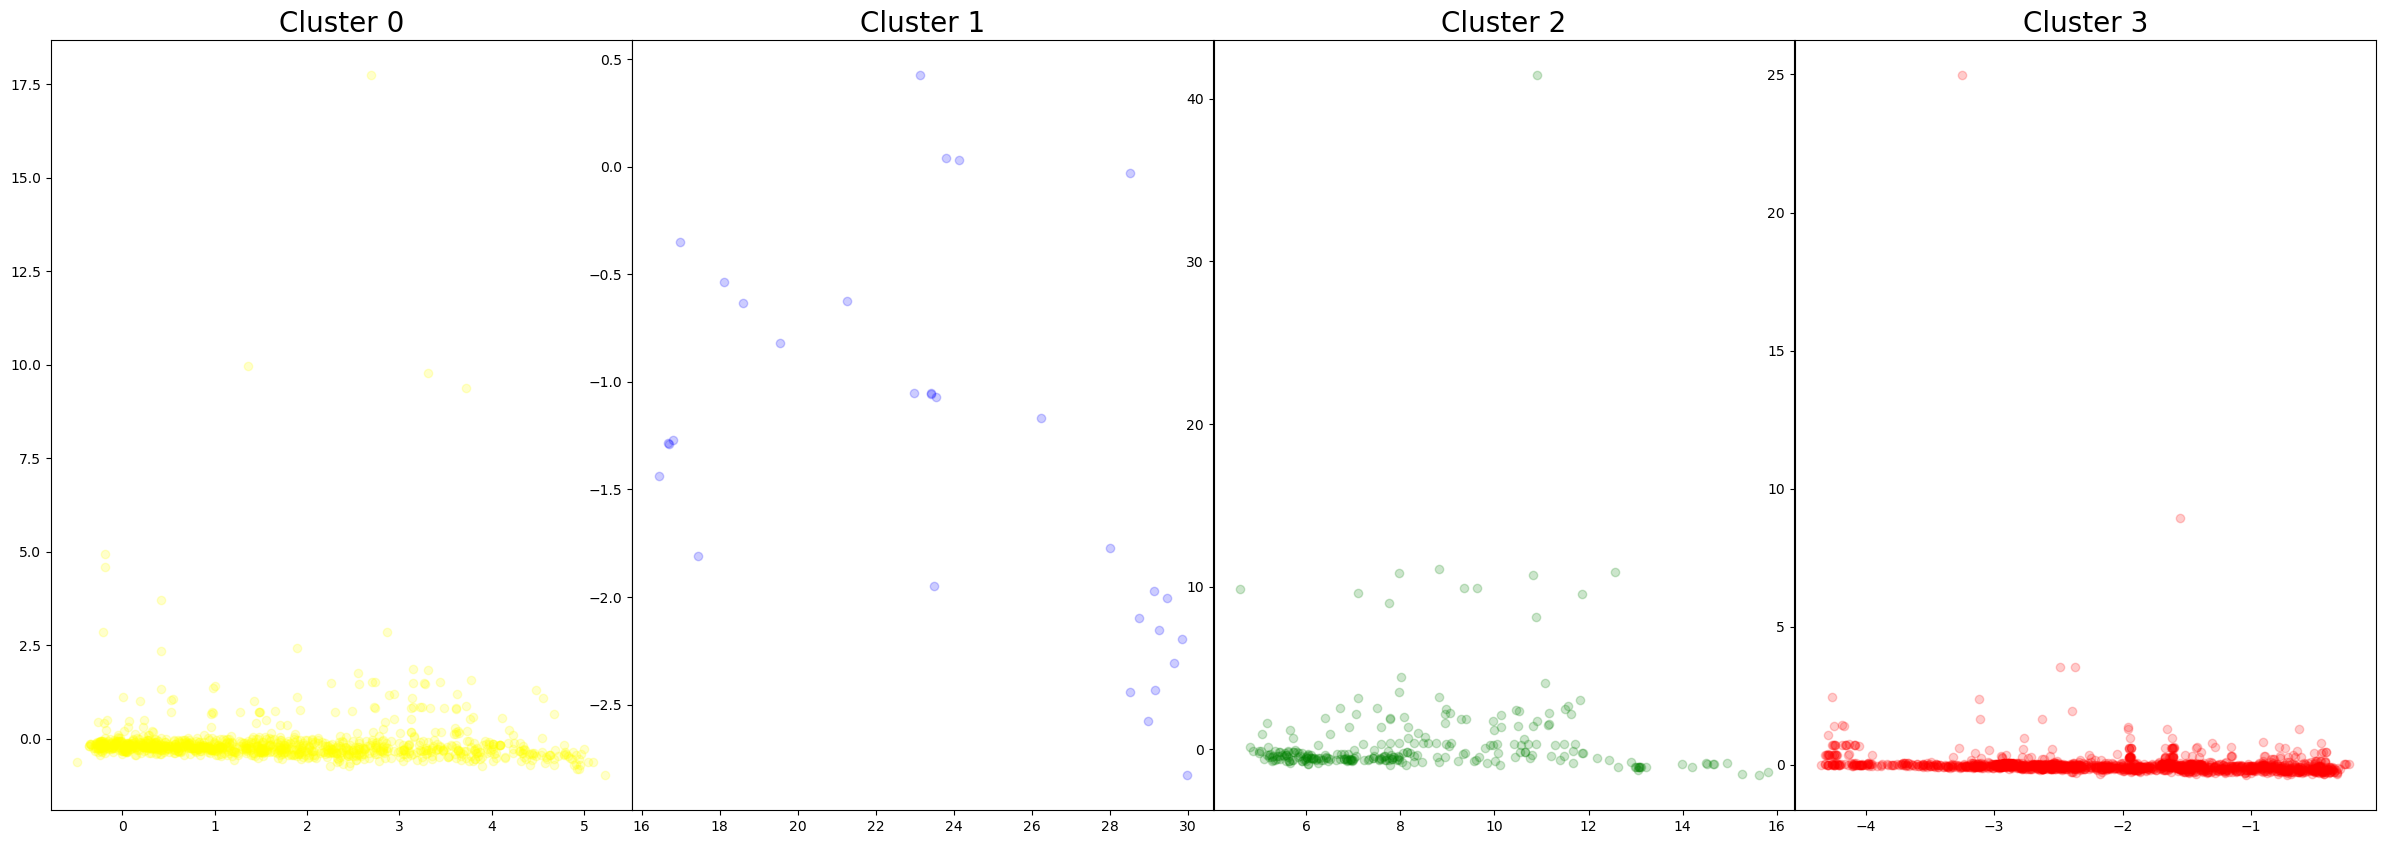

In [61]:
num_clusters = len(set(df['cluster-vectorMaxN-kmeans'])) - (1 if -1 in df['cluster-vectorMaxN-kmeans'].values else 0)

fig, axs = plt.subplots(1, num_clusters, figsize=(30, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.001)
axs = axs.ravel()

for i in range(num_clusters):
    cluster = df[df['cluster-vectorMaxN-kmeans'] == i]
    axs[i].scatter(principalComponents[cluster.index, 0], principalComponents[cluster.index, 1],
                   color=colors[i], alpha=0.2)
    axs[i].set_title(f'Cluster {i}', fontsize=20)

plt.show()

### 3.4. K-means with vectorSeqN

In [62]:
X = np.array(df['vectorSeqN'].tolist())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
k_values = range(1, 10, 1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

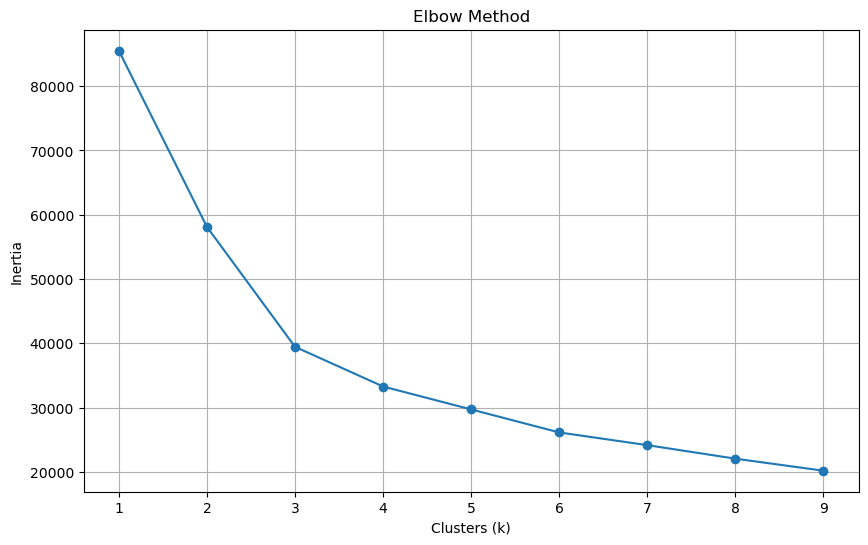

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

In this case, however, when applying the Elbow Method, we observe that the elbow occurs at $k=5$. This indicates that, although increasing the number of clusters to larger values might still reduce the inertia, the benefits in terms of clustering quality become marginal. Therefore, we select 4 clusters as the most balanced option, which provides a clear segmentation of the data without complicating the model unnecessarily.

In [64]:
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_predict(X_scaled)

df['cluster-vectorSeqN-kmeans'] = clusters

#### 3.4.1 Principal Component Analysis (PCA)

In [65]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

pca_3d = PCA(n_components=3)
principalComponents3d = pca_3d.fit_transform(X_scaled)

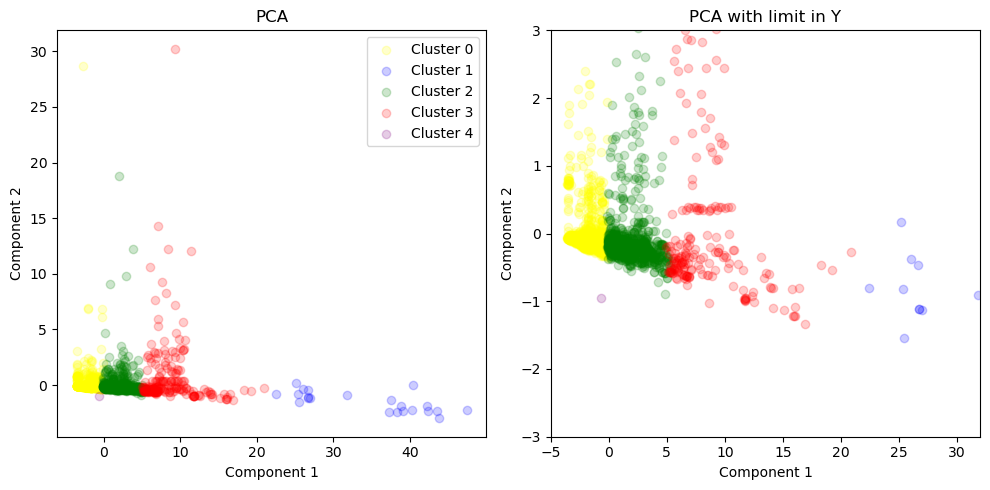

In [66]:
colors = {
    0: 'yellow',
    1: 'blue',
    2: 'green',
    3: 'red',
    4: 'purple'
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

for cluster in colors:
    ax1.scatter(principalComponents[clusters == cluster, 0],
                principalComponents[clusters == cluster, 1],
                color=colors[cluster], alpha=0.2, label=f'Cluster {cluster}')

ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.set_title('PCA')
ax1.legend()

for cluster in colors:
    ax2.scatter(principalComponents[clusters == cluster, 0],
                principalComponents[clusters == cluster, 1],
                color=colors[cluster], alpha=0.2, label=f'Cluster {cluster}')

ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
ax2.set_title('PCA with limit in Y')
ax2.set_ylim(-3, 3)
ax2.set_xlim(-5, 32)

plt.tight_layout()
plt.show()

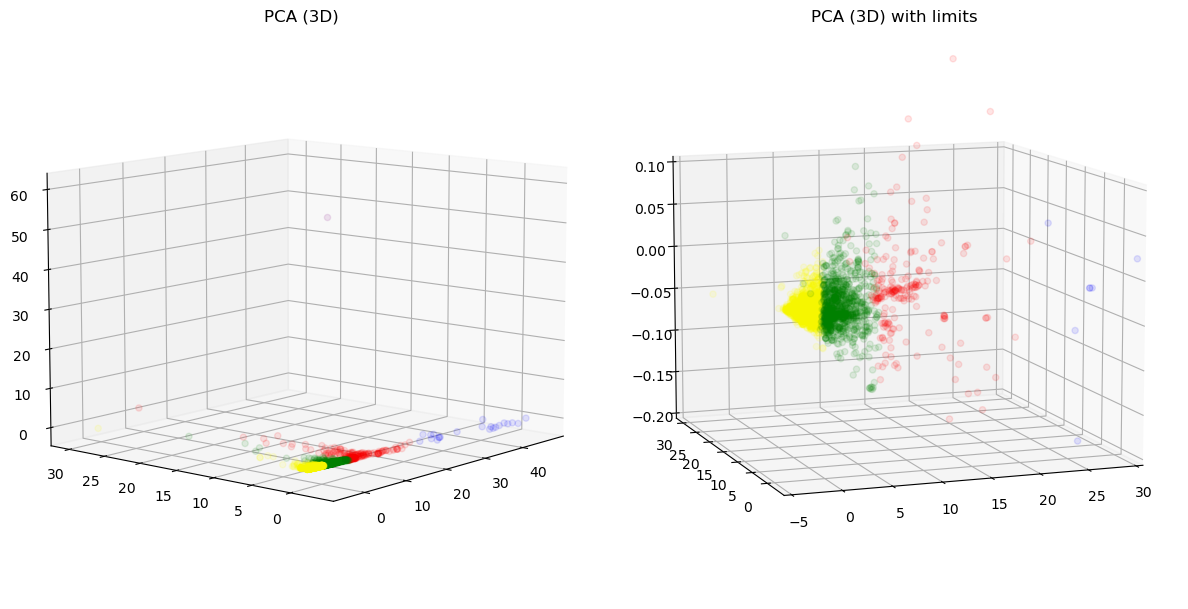

In [67]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
for cluster in colors:
    ax1.scatter(principalComponents3d[clusters == cluster, 0],
                principalComponents3d[clusters == cluster, 1],
                principalComponents3d[clusters == cluster, 2],
                color=colors[cluster], alpha=0.1, label=f'Cluster {cluster}')
ax1.set_title('PCA (3D)')
ax1.view_init(10, 220)

ax2 = fig.add_subplot(122, projection='3d')
for cluster in colors:
    ax2.scatter(principalComponents3d[clusters == cluster, 0],
                principalComponents3d[clusters == cluster, 1],
                principalComponents3d[clusters == cluster, 2],
                color=colors[cluster], alpha=0.1, label=f'Cluster {cluster}')
ax2.set_title('PCA (3D) with limits')
ax2.set_zlim(-0.2, 0.1)
ax2.set_xlim(-5, 30)
ax2.view_init(10, 250)

plt.tight_layout()
plt.show()

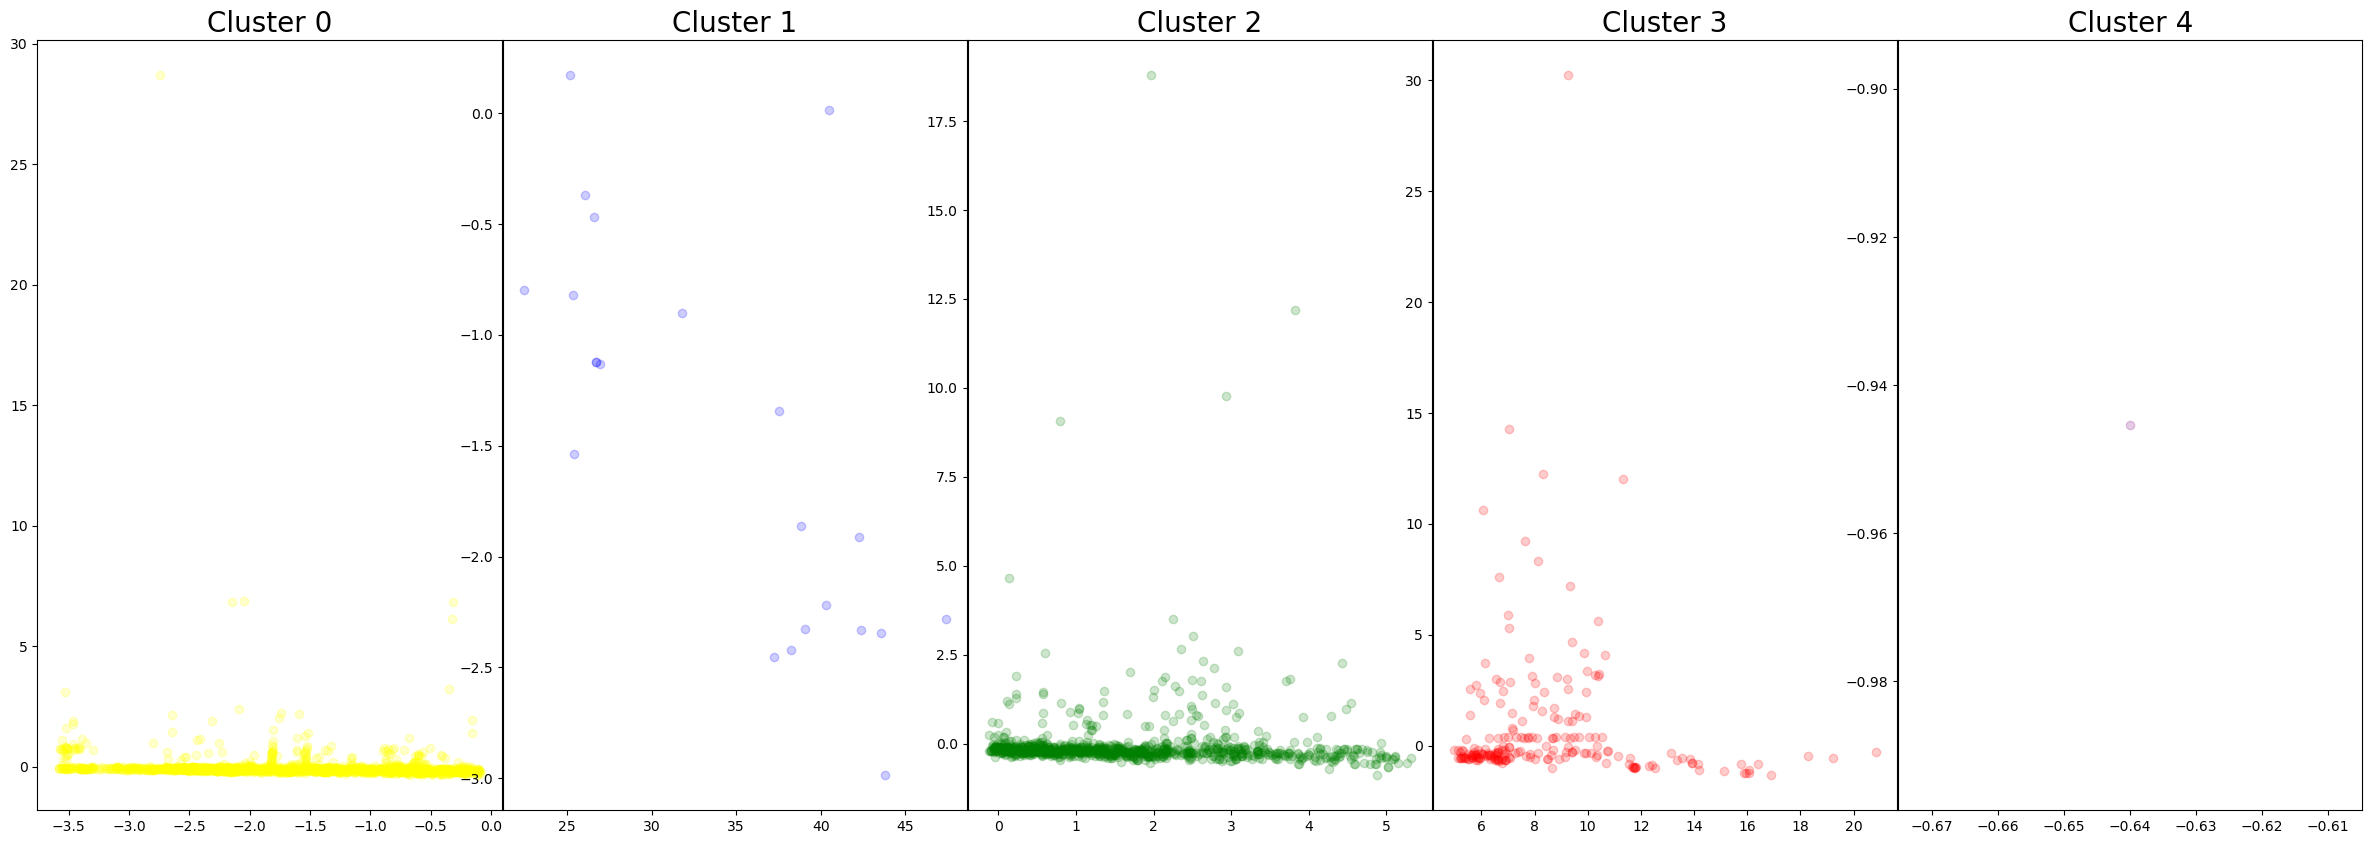

In [68]:
num_clusters = len(set(df['cluster-vectorSeqN-kmeans'])) - (1 if -1 in df['cluster-vectorSeqN-kmeans'].values else 0)

fig, axs = plt.subplots(1, num_clusters, figsize=(30, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.001)
axs = axs.ravel()

for i in range(num_clusters):
    cluster = df[df['cluster-vectorSeqN-kmeans'] == i]
    axs[i].scatter(principalComponents[cluster.index, 0], principalComponents[cluster.index, 1],
                   color=colors[i], alpha=0.2)
    axs[i].set_title(f'Cluster {i}', fontsize=20)

plt.show()

## 4. Analysis of results: Cosine similarity

### 4.1.1. Cosine similarity DBSCAN with VectorMaxN

In [80]:
X = np.array(df['vectorMaxN'].tolist())
X_scaled = StandardScaler().fit_transform(X)

average_similarity = {}

for cluster_id in set(df['cluster-vectorMaxN']):
    if cluster_id == -1:
        continue

    cluster_docs_index = df[df['cluster-vectorMaxN'] == cluster_id].index.tolist()
    
    cluster_size = len(cluster_docs_index)
    similarity_matrix = np.zeros((cluster_size, cluster_size))
    
    for i in range(cluster_size):
        for j in range(cluster_size):
            vec_i = torch.tensor(X_scaled[cluster_docs_index[i]], dtype=torch.float32).unsqueeze(0)
            vec_j = torch.tensor(X_scaled[cluster_docs_index[j]], dtype=torch.float32).unsqueeze(0)

            similarity_matrix[i][j] = F.cosine_similarity(vec_i, vec_j).item()

    avg_similarity = similarity_matrix[np.triu_indices(cluster_size, k=1)].mean()
    average_similarity[cluster_id] = avg_similarity

for cluster_id, avg_sim in average_similarity.items():
    print(f"Cluster {cluster_id}: Average Cosine Similarity = {avg_sim:.4f}")

Cluster 0: Average Cosine Similarity = 0.9330
Cluster 1: Average Cosine Similarity = 0.8764
Cluster 2: Average Cosine Similarity = 0.9562
Cluster 3: Average Cosine Similarity = 0.9075


### 4.1.2. Cosine similarity DBSCAN with VectorSeqN

In [81]:
X = np.array(df['vectorSeqN'].tolist())
X_scaled = StandardScaler().fit_transform(X)

average_similarity = {}

for cluster_id in set(df['cluster-vectorSeqN']):
    if cluster_id == -1:
        continue

    cluster_docs_index = df[df['cluster-vectorSeqN'] == cluster_id].index.tolist()
    
    cluster_size = len(cluster_docs_index)
    similarity_matrix = np.zeros((cluster_size, cluster_size))
    
    for i in range(cluster_size):
        for j in range(cluster_size):
            vec_i = torch.tensor(X_scaled[cluster_docs_index[i]], dtype=torch.float32).unsqueeze(0)
            vec_j = torch.tensor(X_scaled[cluster_docs_index[j]], dtype=torch.float32).unsqueeze(0)

            similarity_matrix[i][j] = F.cosine_similarity(vec_i, vec_j).item()

    avg_similarity = similarity_matrix[np.triu_indices(cluster_size, k=1)].mean()
    average_similarity[cluster_id] = avg_similarity

for cluster_id, avg_sim in average_similarity.items():
    print(f"Cluster {cluster_id}: Average Cosine Similarity = {avg_sim:.4f}")

Cluster 0: Average Cosine Similarity = 0.9361
Cluster 1: Average Cosine Similarity = 0.9409
Cluster 2: Average Cosine Similarity = 0.9286
Cluster 3: Average Cosine Similarity = 0.9107
Cluster 4: Average Cosine Similarity = 0.9313


### 4.1.3. Cosine similarity KMeans with VectorMaxN

In [83]:
X = np.array(df['vectorMaxN'].tolist())
X_scaled = StandardScaler().fit_transform(X)

average_similarity = {}

for cluster_id in set(df['cluster-vectorMaxN-kmeans']):
    cluster_docs_index = df[df['cluster-vectorMaxN-kmeans'] == cluster_id].index.tolist()
    
    cluster_size = len(cluster_docs_index)
    similarity_matrix = np.zeros((cluster_size, cluster_size))
    
    for i in range(cluster_size):
        for j in range(cluster_size):
            vec_i = torch.tensor(X_scaled[cluster_docs_index[i]], dtype=torch.float32).unsqueeze(0)
            vec_j = torch.tensor(X_scaled[cluster_docs_index[j]], dtype=torch.float32).unsqueeze(0)

            similarity_matrix[i][j] = F.cosine_similarity(vec_i, vec_j).item()

    avg_similarity = similarity_matrix[np.triu_indices(cluster_size, k=1)].mean()
    average_similarity[cluster_id] = avg_similarity

for cluster_id, avg_sim in average_similarity.items():
    print(f"Cluster {cluster_id}: Average Cosine Similarity = {avg_sim:.4f}")

Cluster 0: Average Cosine Similarity = 0.2471
Cluster 1: Average Cosine Similarity = 0.8698
Cluster 2: Average Cosine Similarity = 0.7759
Cluster 3: Average Cosine Similarity = 0.6849


### 4.1.4. Cosine similarity KMeans with VectorSeqN

In [85]:
X = np.array(df['vectorSeqN'].tolist())
X_scaled = StandardScaler().fit_transform(X)

average_similarity = {}

for cluster_id in set(df['cluster-vectorSeqN-kmeans']):
    cluster_docs_index = df[df['cluster-vectorSeqN-kmeans'] == cluster_id].index.tolist()
    
    cluster_size = len(cluster_docs_index)
    similarity_matrix = np.zeros((cluster_size, cluster_size))
    
    for i in range(cluster_size):
        for j in range(cluster_size):
            vec_i = torch.tensor(X_scaled[cluster_docs_index[i]], dtype=torch.float32).unsqueeze(0)
            vec_j = torch.tensor(X_scaled[cluster_docs_index[j]], dtype=torch.float32).unsqueeze(0)

            similarity_matrix[i][j] = F.cosine_similarity(vec_i, vec_j).item()

    avg_similarity = similarity_matrix[np.triu_indices(cluster_size, k=1)].mean()
    average_similarity[cluster_id] = avg_similarity

for cluster_id, avg_sim in average_similarity.items():
    print(f"Cluster {cluster_id}: Average Cosine Similarity = {avg_sim:.4f}")

Cluster 0: Average Cosine Similarity = 0.6313
Cluster 1: Average Cosine Similarity = 0.8727
Cluster 2: Average Cosine Similarity = 0.2941
Cluster 3: Average Cosine Similarity = 0.7847
Cluster 4: Average Cosine Similarity = nan


C:\Users\Susana\AppData\Local\Temp\ipykernel_19924\2282083104.py:19: RuntimeWarning: Mean of empty slice.
  avg_similarity = similarity_matrix[np.triu_indices(cluster_size, k=1)].mean()
c:\Users\Susana\anaconda3\envs\aa1\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### cosas que falran
1. dejar bonito el notebook
2. api
3. readme: (trabajo futuro)